# Non-Parametric Regression

## Data Preparation 

In [471]:
import pandas as pd

In [472]:
column_names = ['id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
glass_data = pd.read_csv('./glass.dat', delim_whitespace=True, names=column_names, header=None, skiprows=1)

In [473]:
glass_data

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,WinF
1,2,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,WinF
2,3,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,WinF
3,4,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,WinF
4,5,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,WinF
...,...,...,...,...,...,...,...,...,...,...,...
209,210,-1.77,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,Head
210,211,-1.15,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,Head
211,212,2.65,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,Head
212,213,-1.49,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,Head


In [474]:
glass_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  Type    214 non-null    object 
dtypes: float64(9), int64(1), object(1)
memory usage: 18.5+ KB


Check for Null values in data 

In [475]:
glass_data.isna().sum().all()

False

We will perform Kernel Regression over the values of 'Al' content to estimate the refractive index of the Glass.

In [476]:
glass_data = glass_data[['RI','Al']].to_numpy()

In [477]:
y = glass_data[:, 0]
X = glass_data[:, 1]

In [478]:
y.shape

(214,)

In [479]:
X.shape

(214,)

## Inference From The Data

In [480]:
import matplotlib.pyplot as plt
import numpy as np

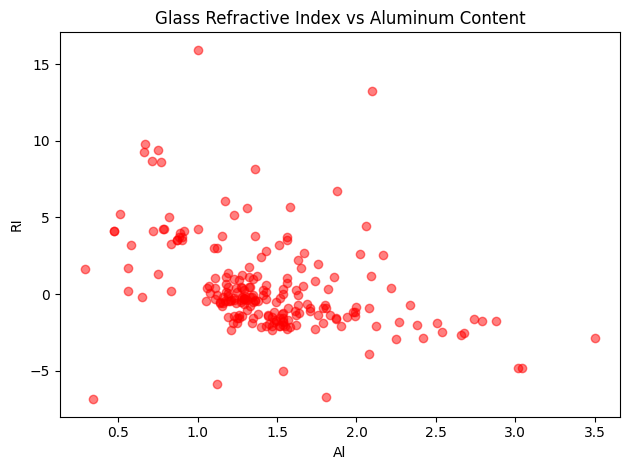

In [481]:
plt.plot(X, y, 'o', color='red', alpha=0.5)
plt.xlabel('Al')
plt.ylabel('RI')
plt.title("Glass Refractive Index vs Aluminum Content")
plt.tight_layout()
plt.show()

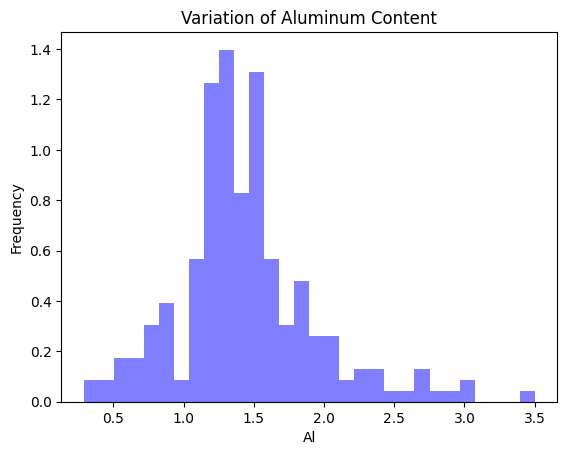

In [482]:

plt.hist(X, bins=30, density=True, alpha=0.5, color='blue')
plt.xlabel('Al')
plt.ylabel('Frequency')
plt.title("Variation of Aluminum Content")
plt.show()

Range Of Values of X

In [483]:
np.min(X), np.max(X)

(0.29, 3.5)

In [484]:
import numpy as np

In [485]:
# Calculate the corrlation function
corr_dataset = np.corrcoef(X, y)[0, 1]
corr_dataset

-0.4073260340813923

## Performing Regression

### Defining Kernel Function

This functions represent the <i>Nadaraya-Watson</i> for the respective kernels

In [486]:
#Guassian Kernel
def guassian_kernel_estimated_function(x,X,y,bandwidth,epslion=1e-5):
    return np.sum(np.exp(-np.square(x-X)/(2*bandwidth**2))*y)/(np.sum(np.exp(-np.square(x-X)/(2*bandwidth**2)))+epslion)

In [487]:
#Uniform Kernel
def uniform_kernel_estimated_function(x,X,y,bandwidth,epsilon=0.00001):
	return np.sum((np.abs(x-X)<bandwidth)*y)/(np.sum(np.abs(x-X)<bandwidth)+epsilon)

In [488]:
#Epanechnikov Kernel
def epanechnikov_kernel_estimated_function(x,X,y,bandwidth):
	return np.sum((1-np.square((x-X)/bandwidth))*y)/np.sum(1-np.square((x-X)/bandwidth) + 1e-5)

### Kernel Regression 

In [489]:
def kernel_regression(X_train, y_train, X, bandwidth, kernel):
    """
    This finds the value of the estimated kernel regression function at the points in X
    
    X_train: training data => np.array of shape (n_samples,1)
    y_train: training labels => np.array of shape (n_samples,)
    X: test data => np.array of shape (n_samples,1)
    bandwidth: bandwidth of the kernel
    kernel_type: type of kernel to use
    """
    y_pred = np.zeros(len(X))
    for i in range(len(X)):
        y_pred[i] = kernel(X[i], X_train, y_train, bandwidth)
    return y_pred

In [490]:
def loss(y_true, y_pred):
    """
    Estimated risk function
    """
    return np.mean(np.square(y_true-y_pred))

In [491]:
def cross_validate(X_train, y_train, X, y, bandwidths, kernel):
    """
    This function performs cross validation across bandwidths on a given
    
    X_train: training data => np.array of shape (n_samples,1)
    y_train: training labels => np.array of shape (n_samples,)
    X: test data => np.array of shape (n_samples,1)
    y: test labels => np.array of shape (n_samples,)
    
    to find the best bandwidth
    """
    losses = np.zeros(len(bandwidths))
    for i, bandwidth in enumerate(bandwidths):
        y_pred = kernel_regression(X_train, y_train, X, bandwidth, kernel)
        losses[i] = loss(y, y_pred)
    return losses

In [492]:
def k_fold_validation(X, y, k, bandwidths, kernel):
    """
    Using the k fold cross validation technique
    """
    n = len(y)
    indices = np.random.permutation(n)
    losses = np.zeros((k, len(bandwidths)))
    for i in range(k):
        train_indices = np.concatenate([indices[:i*n//k], indices[(i+1)*n//k:]])
        # print(train_indices.size)
        test_indices = indices[i*n//k:(i+1)*n//k]
        # print(test_indices.size)
        losses[i] = cross_validate(X[train_indices], y[train_indices], X[test_indices], y[test_indices], bandwidths, kernel)
    return np.mean(losses, axis=0)

In [493]:
def plot_cross_validation(bandwidths, losses, kernel):
	plt.plot(bandwidths, losses)
	plt.xlabel('Bandwidth')
	plt.ylabel('Estimated Risk')
	plt.title('Cross Validation for Kernel: ' + kernel.__name__)
	plt.show()

In [494]:
def plot_residuals(y_pred, y_true, kernel):
    plt.plot(y_true, y_pred-y_true, 'o', alpha=0.5)
    plt.xlabel('True Value')
    plt.ylabel('Residual')
    plt.title('Residuals for Kernel: ' + kernel.__name__)
    plt.show()
    

### Uniform Kernel

In [495]:
kernel = uniform_kernel_estimated_function

In [496]:
bandwidths = np.linspace(0.01, 1.0, 100)

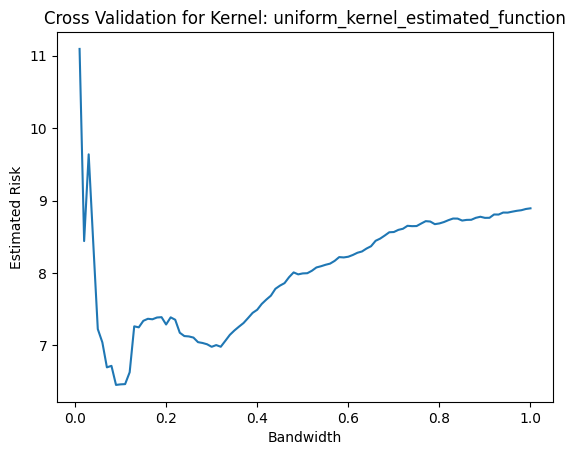

In [497]:
losses = k_fold_validation(X, y, 10,  bandwidths, kernel)
plot_cross_validation(bandwidths, losses, kernel)

In [498]:
best_bandwidth = bandwidths[np.argmin(losses)]
best_bandwidth

0.09

In [499]:
losses_uniform = losses

The Bandwidth corresoponding to the Minimum Estimated Risk is 0.10

Generating the line for the Kernel Density Plot

In [500]:
x_gen = np.linspace(np.min(X)+0.05, np.max(X)-0.5, 1000)

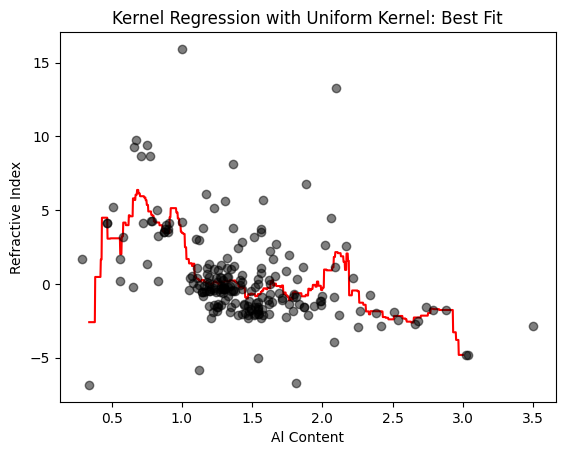

In [501]:
y_gen1 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen1[i] = uniform_kernel_estimated_function(x_gen[i], X, y, bandwidth=best_bandwidth)
plt.plot(x_gen, y_gen1, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5)
plt.xlabel('Al Content')
plt.ylabel('Refractive Index')
plt.title('Kernel Regression with Uniform Kernel: Best Fit')
plt.show()

In [502]:
y_gen_bestfit_uniform = y_gen1

Oversmoothed Plot

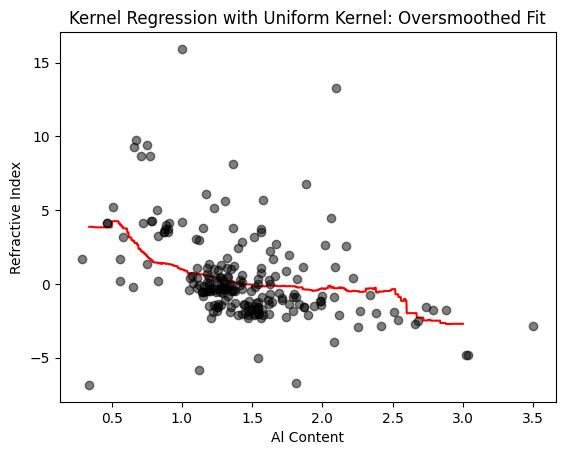

In [503]:
bandwidth = 0.5
y_gen2 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen2[i] = uniform_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth)
plt.plot(x_gen, y_gen2, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5)
plt.xlabel('Al Content')
plt.ylabel('Refractive Index')
plt.title('Kernel Regression with Uniform Kernel: Oversmoothed Fit')
plt.show()

Undersmoothed Plot

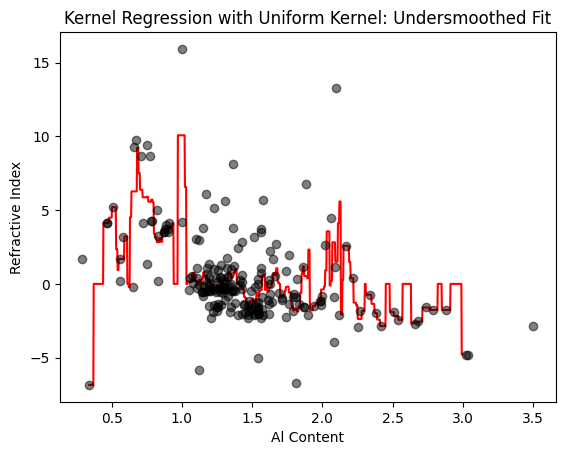

In [504]:
bandwidth = 0.03
y_gen3 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen3[i] = uniform_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth)
plt.plot(x_gen, y_gen3, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5)
plt.xlabel('Al Content')
plt.ylabel('Refractive Index')
plt.title('Kernel Regression with Uniform Kernel: Undersmoothed Fit') 	
plt.show()

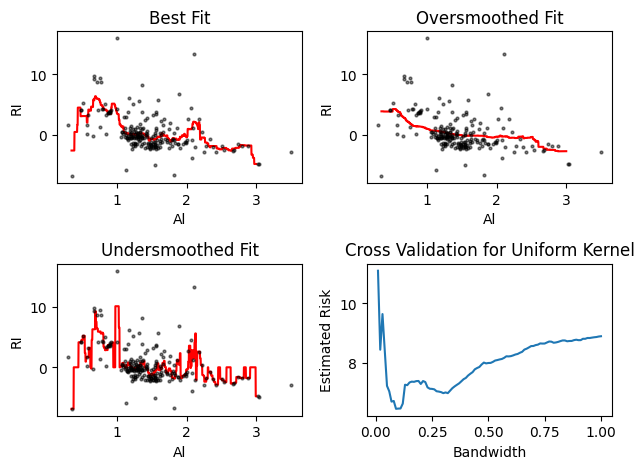

In [505]:
# plt.title('Kernel Regression with Gaussian Kernel')
# combine all 4 plots into one
plt.subplot(2, 2, 1)
plt.plot(x_gen, y_gen1, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5, markersize=2)
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Best Fit')
plt.subplot(2, 2, 2)
plt.plot(x_gen, y_gen2, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5, markersize=2) 
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Oversmoothed Fit')
plt.subplot(2, 2, 3)
plt.plot(x_gen, y_gen3, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5, markersize=2)
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Undersmoothed Fit')
plt.subplot(2, 2, 4)
plt.plot(bandwidths, losses)
plt.xlabel('Bandwidth')
plt.ylabel('Estimated Risk')
plt.title('Cross Validation for Uniform Kernel')
plt.tight_layout()
plt.show()

## Guassian Kernel

In [506]:
bandwidths = np.linspace(0.01, 1.0, 100)

In [507]:
kernel  = guassian_kernel_estimated_function

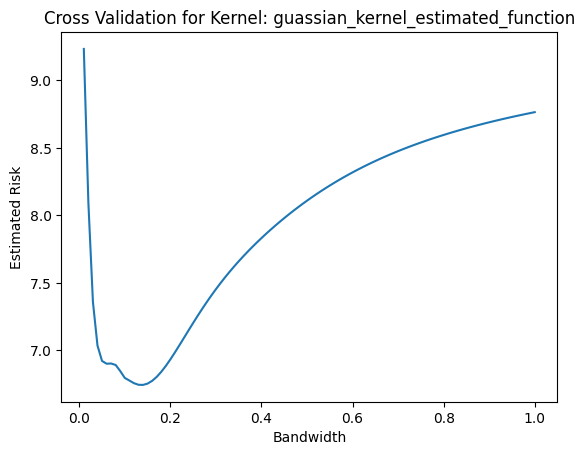

In [508]:
losses = k_fold_validation(X, y, 10,  bandwidths, kernel)
plot_cross_validation(bandwidths, losses, kernel)

In [509]:
losses_gaussian = losses

In [510]:
best_bandwidth = bandwidths[np.argmin(losses)]
best_bandwidth

0.14

The Bandwidth Corresponding the Minimum Estimated Risk is 0.15

In [511]:
x_gen = np.linspace(np.min(X), np.max(X), 1000)

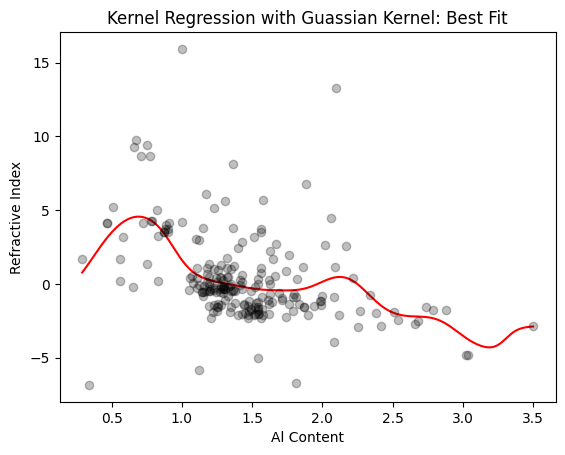

In [512]:
y_gen1 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen1[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=0.15)
plt.plot(x_gen, y_gen1, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.25)
plt.xlabel('Al Content')
plt.ylabel('Refractive Index')
plt.title('Kernel Regression with Guassian Kernel: Best Fit')
plt.show()

In [513]:
y_gen_bestfit_gaussian = y_gen1

Undersmoothed Plot

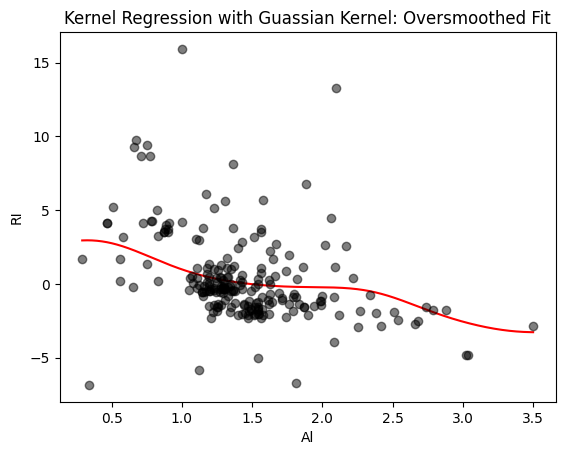

In [514]:
bandwidth = 0.35
y_gen2 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen2[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth)
plt.plot(x_gen, y_gen2, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5)
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Kernel Regression with Guassian Kernel: Oversmoothed Fit')
plt.show()

Undersmoothed

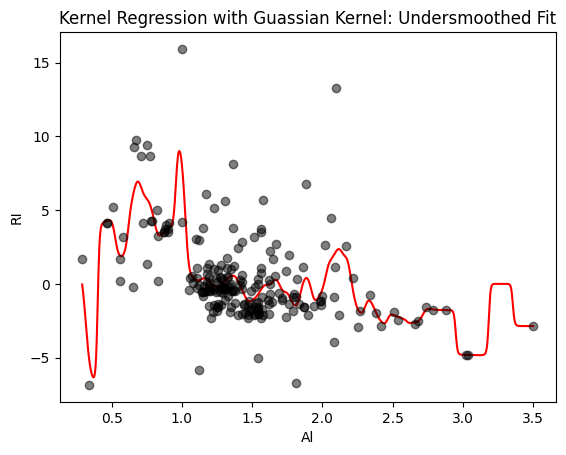

In [515]:
bandwidth = 0.03
y_gen3 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen3[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth)
plt.plot(x_gen, y_gen3, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5)
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Kernel Regression with Guassian Kernel: Undersmoothed Fit') 	
plt.show()

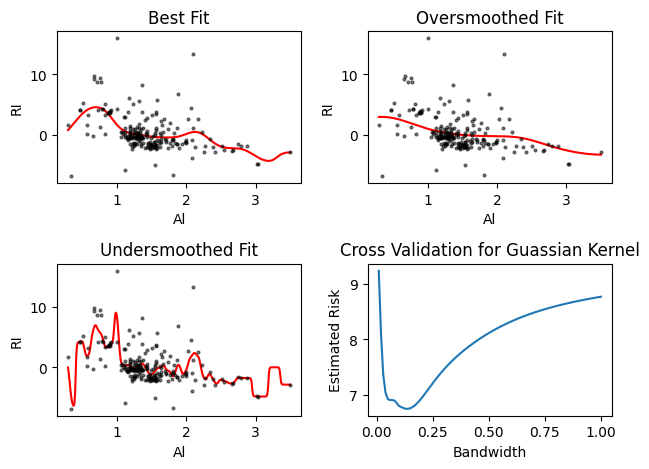

In [516]:
# plt.title('Kernel Regression with Gaussian Kernel')
# combine all 4 plots into one
plt.subplot(2, 2, 1)
plt.plot(x_gen, y_gen1, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5, markersize=2)
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Best Fit')
plt.subplot(2, 2, 2)
plt.plot(x_gen, y_gen2, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5, markersize=2) 
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Oversmoothed Fit')
plt.subplot(2, 2, 3)
plt.plot(x_gen, y_gen3, color='red')
plt.plot(X, y, 'o', color='black', alpha=0.5, markersize=2)
plt.xlabel('Al')
plt.ylabel('RI')
plt.title('Undersmoothed Fit')
plt.subplot(2, 2, 4)
plt.plot(bandwidths, losses)
plt.xlabel('Bandwidth')
plt.ylabel('Estimated Risk')
plt.title('Cross Validation for Guassian Kernel')
plt.tight_layout()
plt.show()

## Analysing Impact of Kernel Choice

Visualizing the 10-Fold Cross Validation Loss for Unifor And Gaussian Kernel

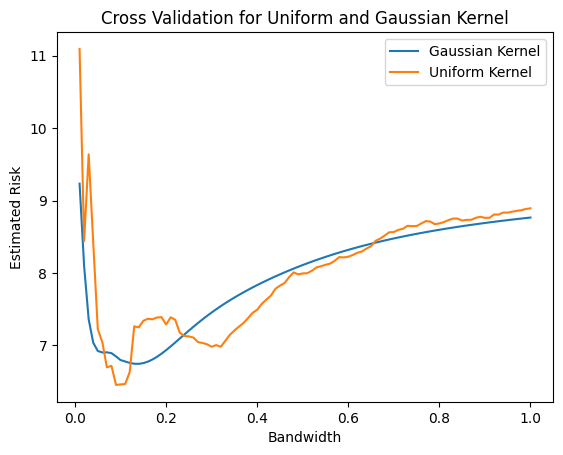

In [517]:
plt.plot(bandwidths, losses_gaussian, label='Gaussian Kernel')
plt.plot(bandwidths, losses_uniform, label='Uniform Kernel')
plt.xlabel('Bandwidth')
plt.ylabel('Estimated Risk')
plt.title('Cross Validation for Uniform and Gaussian Kernel')
plt.legend()
plt.show()

In [518]:
(np.min(losses_gaussian) - np.min(losses_uniform)) / np.min(losses_uniform)

0.04514474442452106

Visualising the Regression Lines for Gaussian And Uniform Kernels for Bandwidth of 0.13

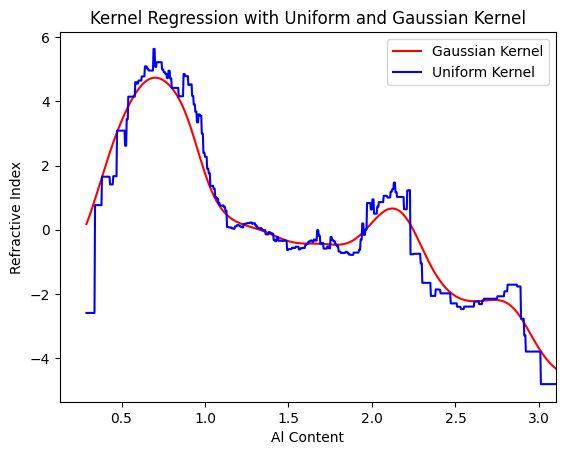

In [519]:
x_gen = np.linspace(np.min(X), np.max(X), 1000)
bandwidth = 0.13
y_gen1 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen1[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth)
y_gen2 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen2[i] = uniform_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth)
plt.plot(x_gen, y_gen1, color='red', label='Gaussian Kernel')
plt.plot(x_gen, y_gen2, color='blue', label='Uniform Kernel')
# plt.plot(X, y, 'o', color='black', alpha=0.5)
plt.xlabel('Al Content')
plt.ylabel('Refractive Index')
plt.title('Kernel Regression with Uniform and Gaussian Kernel')
plt.legend()
plt.xlim(right=3.1)
plt.show()

## Analysing Impact of Bandwidth Choice

Visualizing the regression line for different bandwidths for the same kernel.

Text(0.5, 1.0, 'Kernel Regression with Eposhnikov Kernel')

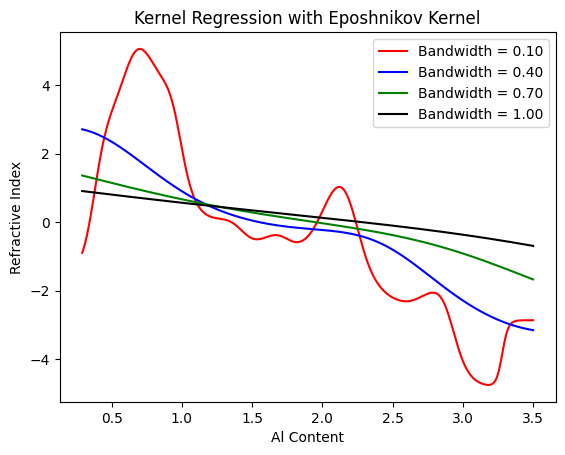

In [520]:
x_gen = np.linspace(np.min(X), np.max(X), 500)
bandwidth1 = 0.10
bandwidth2 = 0.40
bandwidth3 = 0.70
bandwidth4 = 1
y_gen1 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen1[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth1)
y_gen2 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen2[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth2)
y_gen3 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen3[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth3)
y_gen4 = np.zeros(len(x_gen))
for i in range(len(x_gen)):
	y_gen4[i] = guassian_kernel_estimated_function(x_gen[i], X, y, bandwidth=bandwidth4)
plt.plot(x_gen, y_gen1, color='red', label='Bandwidth = 0.10')
plt.plot(x_gen, y_gen2, color='blue', label='Bandwidth = 0.40')
plt.plot(x_gen, y_gen3, color='green', label='Bandwidth = 0.70')
plt.plot(x_gen, y_gen4, color='black', label='Bandwidth = 1.00')
plt.xlabel('Al Content')
plt.ylabel('Refractive Index')
plt.legend()
plt.title('Kernel Regression with Eposhnikov Kernel')

The choice of bandwidth clearly affects the regression line